# **SETUP AND INSTALLATIONS**

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
# #To upload the Kaggle.json file
# from google.colab import files
# files.upload()

# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d cdart99/food20dataset

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"vrindaprabhu","key":"56daa2ea01b5278840ddb4c786c6087a"}'}

In [ ]:
# !unzip food20dataset.zip
# !rm -rf food20dataset/train_set/noodles/
# !rm -rf food20dataset/test_set/noodles/

# !rm -rf food20dataset/train_set/'kathi roll'/
# !rm -rf food20dataset/test_set/'kathi roll'/

In [ ]:
# cp -rf food20dataset.zip MyDrive/MyDrive/FastAIFiles/

In [ ]:
#hide
!pip install fastbook

     |████████████████████████████████| 727kB 4.1MB/s 
     |████████████████████████████████| 1.2MB 12.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 16.5MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


## **BEHIND THE SCENE**

### **Imports**

In [ ]:
from fastai.vision.all import *

### **Getting the data ready**

In [ ]:
path = Path('food18data/')
path.ls()

(#2) [Path('train_set'),Path('test_set')]

In [ ]:
food_data = ImageDataLoaders.from_folder(path, 
                                         train='train_set', valid_pct=0.2,
                                         item_tfms=Resize(400),
                                         batch_tfms=[Resize(224), Normalize(imagenet_stats)])

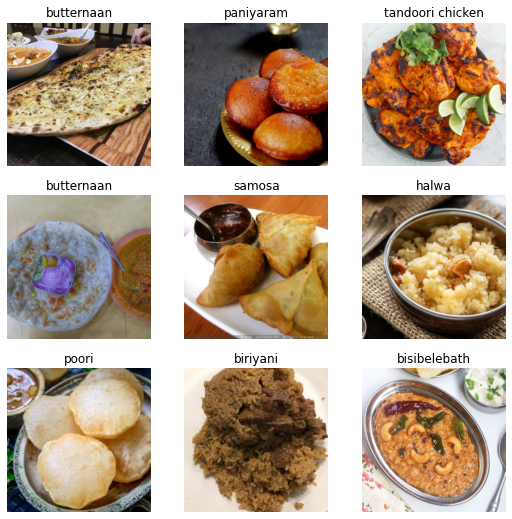

In [ ]:
food_data.show_batch()

### **Training**

#### Pure Finetuning

Fine tune has two stages:


1.   **Stage 1:** Train the last layer


*  Start with a pre-trained model’s weights (pre-trained on imagenet). The last layer is removed and a new layer for our classes is added with random weights. Freeze the pre-trained weights as they are “good” starting weights, and train the last layer (as they are random weights). 
*  When the last layer is performing fine i.e. it’s weights are also “good” starting weights we move to stage 2.

2.   **Stage 2:** Unfreeze and train
Now we unfreeze all the weights and try to train the whole model.

In [ ]:
learn = cnn_learner(food_data, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,3.040792,0.894393,0.269444,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.863462,0.436907,0.125000,00:48
1,0.527566,0.347153,0.088889,00:48


#### Using the Learning Rate Finder

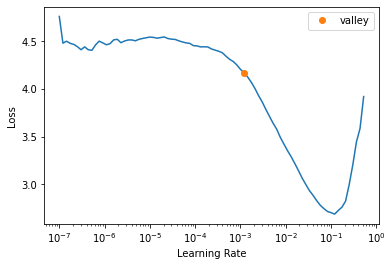

In [ ]:
learn = cnn_learner(food_data, resnet34, metrics=error_rate)
lr_meta = learn.lr_find()

In [ ]:
print (lr_meta) #Let us use the suggested LR

SuggestedLRs(valley=tensor(0.0012))


In [ ]:
learn = cnn_learner(food_data, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.0012)

epoch,train_loss,valid_loss,error_rate,time
0,3.429369,1.206125,0.350000,00:46


epoch,train_loss,valid_loss,error_rate,time
0,1.342659,0.648167,0.169444,00:48
1,0.838284,0.508341,0.150000,00:48


#### Fine Tune by Manual Unfreeze

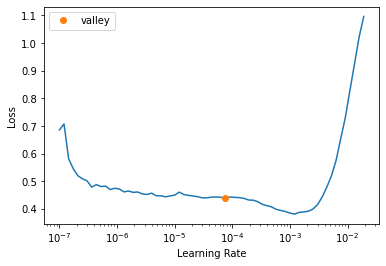

In [ ]:
learn.unfreeze()
lr_meta = learn.lr_find()

In [ ]:
print (lr_meta)

SuggestedLRs(valley=tensor(7.5858e-05))


#### Use Discriminative Learning Rates

In [ ]:
learn = cnn_learner(food_data, resnet34, metrics=error_rate)
learn.fine_tune(3, 1e-3)

learn.unfreeze()

learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,3.688552,1.385378,0.397222,00:46


epoch,train_loss,valid_loss,error_rate,time
0,1.583031,0.702395,0.205556,00:49
1,1.038752,0.447459,0.113889,00:48
2,0.715033,0.412929,0.113889,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.369112,0.370239,0.105556,00:48
1,0.304806,0.320326,0.094444,00:49
2,0.222401,0.307566,0.091667,00:49
3,0.161132,0.301828,0.080556,00:49
4,0.119852,0.261749,0.061111,00:49
5,0.087482,0.263646,0.066667,00:48
6,0.064113,0.273193,0.072222,00:49
7,0.046040,0.260467,0.063889,00:49
8,0.033110,0.252023,0.061111,00:50
9,0.026338,0.253877,0.061111,00:48


### **Performance Analysis**

#### Loss Curves

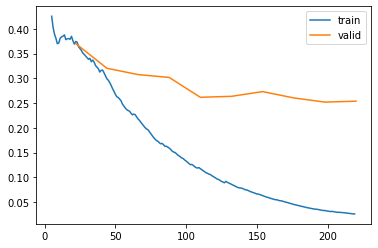

In [ ]:
learn.recorder.plot_loss()

#### Classification Interpretation

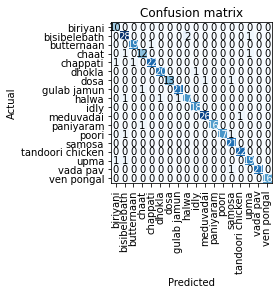

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

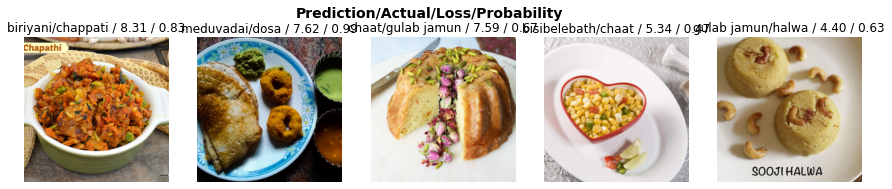

In [ ]:
interp.plot_top_losses(5, nrows=1)

#### Testing with the unseen and labelled test batch. 
[This](https://forums.fast.ai/t/v2-images-questions-on-how-to-get-predictions-properly-multilple-sources-with-diff/63314/16)  link is helpful for batch predictions.

Add the test batch to the existing learner

In [ ]:
test_path = Path('food18data/test_set')
images = get_image_files(test_path)
images[0]

Path('test_set/samosa/samosatest (16).jpg')

In [ ]:
test_dl = learn.dls.test_dl(images, with_labels=True)

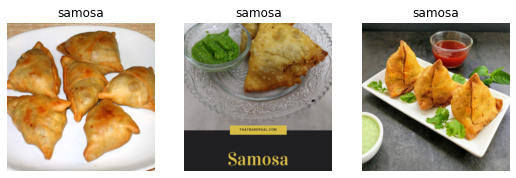

In [ ]:
test_dl.show_batch(max_n=3)

Interpretation

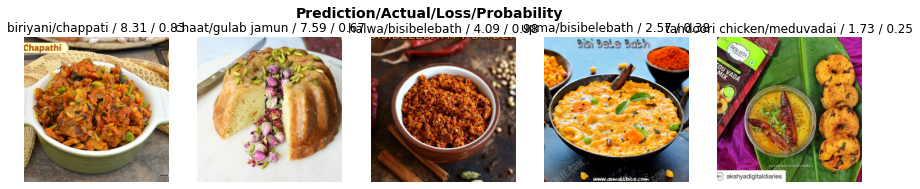

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp2.plot_top_losses(5, nrows=1)

Batch prediction and individual decoding. 

In [ ]:
pred_tensor, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
# #loop to spit out formatted results from get_preds
# for index,item in enumerate(pred_tensor):
#     prediction = learn.dls.categorize.decode(np.argmax(item)).upper()
#     confidence = max(item)
#     percent = float(confidence)
#     print(f"{prediction}   {percent*100:.2f}% confidence.   Image = {learn.dl.items[index].name}")

### **Saving the model for inference**

In [ ]:
#Refuses to be saved in other folders. Should check why.
learn.export('food_classifier.pkl')

Infer on the saved model

In [ ]:
learn_inf = load_learner(path/'food_classifier.pkl')

In [ ]:
test_fname = "food18data/test_set/dosa/dosatest (1).jpg"
pred, idx, pred_percentage = learn_inf.predict(test_fname)
print (f"Predicted {pred} with a confidence of {pred_percentage[idx]:.2f}")

Predicted dosa with a confidence of 1.00


## **TAKE IT TO THE FRONT**

In Part B of the notebook